Now that I am slightly familiar with the code required, I am going to experiment.
The first thing to do is to see if the plain code works with fastai.
I wonder if the changes that have been made are for the worst?

In [1]:
from fastai.vision import *

import pandas as pd

import torch
from torch.optim import Optimizer

from efficientnet_pytorch import EfficientNet

In [2]:
PROJECT_ROOT = Path('.').absolute().parents[0]
DATA_FOLDER = PROJECT_ROOT / 'data' / 'processed'
TRAIN_CSV = DATA_FOLDER / 'train.csv'
VALID_CSV = DATA_FOLDER / 'valid.csv'
CARS_FOLDER = DATA_FOLDER / 'car_data'

MODEL_NAME = 'efficientnet-b3'
IMAGE_SIZE = EfficientNet.get_image_size(MODEL_NAME)
BATCH_SIZE = 7

### Create the Learner

In [17]:
np.random.seed(42)
data = (
    ImageList.from_folder(CARS_FOLDER/'train')
        .split_by_rand_pct(0.1)
        .label_from_folder()
        .transform(tfms=get_transforms(), size=IMAGE_SIZE, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats)
)

In [18]:
model = EfficientNet.from_pretrained(MODEL_NAME)

Loaded pretrained weights for efficientnet-b3


In [19]:
learn = Learner(
    data,
    model,
    metrics=[accuracy]
)

### Train the Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-03


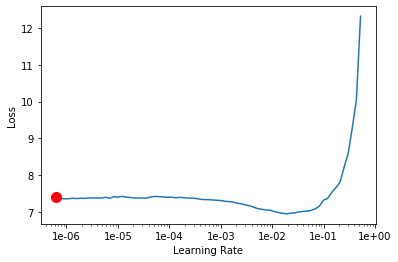

In [6]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [7]:
LEARNING_RATE = 1.45E-03

In [9]:
learn.fit_one_cycle(1, max_lr=LEARNING_RATE)

In [10]:
learn.save('stage-1-cars-efficientnet-b3')

The performance was worse than the last time.
Lets try unfreezing it.

In [6]:
learn.load('stage-1-cars-efficientnet-b3') ; None

In [7]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 1.74E-04


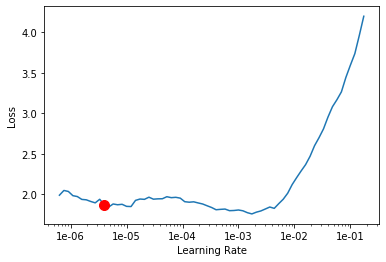

In [8]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [8]:
LEARNING_RATE = 3E-3

In [9]:
learn.fit_one_cycle(1, max_lr=slice(LEARNING_RATE/100,LEARNING_RATE))

ZeroDivisionError: division by zero

So the unfreezing breaks the model.
This must be what the split was for.

In [3]:
model = EfficientNet.from_pretrained(MODEL_NAME)

np.random.seed(42)
data = (
    ImageList.from_folder(CARS_FOLDER/'train')
        .split_by_rand_pct(0.1)
        .label_from_folder()
        .transform(tfms=get_transforms(), size=IMAGE_SIZE, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats)
)

learn = Learner(
    data,
    model,
    metrics=[accuracy]
)

Loaded pretrained weights for efficientnet-b3


In [11]:
learn.split([
    [learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:12]],
    [learn.model._blocks[12:],learn.model._conv_head], 
    [learn.model._bn1, learn.model._fc]
]) ; None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 1.32E-03


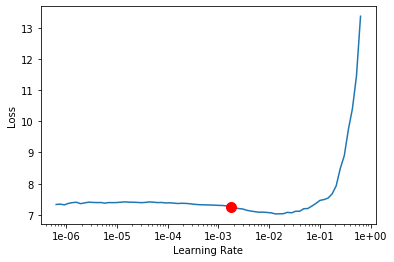

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
learn.unfreeze()

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

So it does look like the split permits the model to be unfrozen. The next thing to evaluate is the replacement of the linear layer. This is the prediction layer.

In [20]:
model = EfficientNet.from_pretrained(MODEL_NAME)

np.random.seed(42)
data = (
    ImageList.from_folder(CARS_FOLDER/'train')
        .split_by_rand_pct(0.1)
        .label_from_folder()
        .transform(tfms=get_transforms(), size=IMAGE_SIZE, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats)
)

learn = Learner(
    data,
    model,
    metrics=[accuracy]
)

Loaded pretrained weights for efficientnet-b3


In [5]:
model._fc

Linear(in_features=1536, out_features=1000, bias=True)

In [10]:
data.c

196

In [11]:
model.add_module('_fc',nn.Linear(1536, data.c))

In [12]:
learn.model._fc

Linear(in_features=1536, out_features=196, bias=True)

So that makes the linear layer make a lot more sense. Now it would be good to make the split.

In [13]:
LEARNING_RATE = 3E-3

In [15]:
learn.freeze_to(-1)

In [16]:
learn.freeze_to??

Signature: learn.freeze_to(n: int) -> None
Source:   
    def freeze_to(self, n:int)->None:
        "Freeze layers up to layer group `n`."
        for g in self.layer_groups[:n]:
            for l in g:
                if not self.train_bn or not isinstance(l, bn_types): requires_grad(l, False)
        for g in self.layer_groups[n:]: requires_grad(g, True)
        self.create_opt(defaults.lr)
File:      ~/.local/share/virtualenvs/dl-efficientnet-2HnqaFbf/lib/python3.7/site-packages/fastai/basic_train.py
Type:      method


In [17]:
learn.layer_groups

[Sequential(
   (0): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
   (1): ParameterModule()
   (2): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
   (3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
   (4): ParameterModule()
   (5): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
   (6): Identity()
   (7): ParameterModule()
   (8): ParameterModule()
   (9): Identity()
   (10): ParameterModule()
   (11): ParameterModule()
   (12): Identity()
   (13): ParameterModule()
   (14): BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
   (15): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
   (16): ParameterModule()
   (17): BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
   (18): Identity()
   (19): ParameterModule()
   (20): ParameterModule()
   (21): Identity()
   (22): ParameterModule()
   (23): ParameterMo

In [27]:
learn.layer_groups = [
    nn.Sequential(learn.layer_groups[0][:-1]),
    nn.Sequential(learn.layer_groups[0][-1])
]

In [28]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 3.98E-03


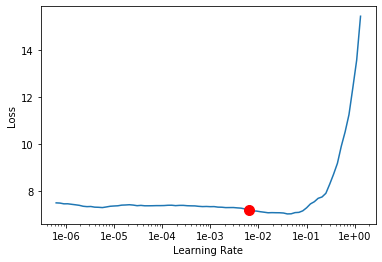

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
LEARNING_RATE = 3E-3

In [31]:
learn.fit_one_cycle(1, max_lr=LEARNING_RATE)

So this does seem to freeze the model until the final layer?
How well can this be finetuned?